<a href="https://colab.research.google.com/github/DavyMorgan/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invariant Risk Minimization

This is an attempt to reproduce the "Colored MNIST" experiments from the
paper [Invariant Risk Minimization](https://arxiv.org/abs/1907.02893)
by Arjovsky, et. al.

In [5]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

## Prepare the colored MNIST dataset

We define three environments (two training, one test) by randomly splitting the MNIST dataset in thirds and transforming each example as follows:
1. Assign a binary label y to the image based on the digit: y = 0 for digits 0-4
and y = 1 for digits 5-9.
2. Flip the label with 25% probability.
3. Color the image either red or green according to its (possibly flipped) label.
4. Flip the color with a probability e that depends on the environment: 20% in
the first training environment, 10% in the second training environment, and
90% in the test environment.

In [13]:
def color_grayscale_arr(arr, red=True):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
      if np.random.uniform() < 0.25:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
      if idx < 20000:
        # 20% in the first training environment
        if np.random.uniform() < 0.2:
          color_red = not color_red
      elif idx < 40000:
        # 10% in the first training environment
        if np.random.uniform() < 0.1:
          color_red = not color_red
      else:
        # 90% in the test environment
        if np.random.uniform() < 0.9:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, red=color_red)

      if idx < 20000:
        train1_set.append((Image.fromarray(colored_arr), binary_label))
      elif idx < 40000:
        train2_set.append((Image.fromarray(colored_arr), binary_label))
      else:
        test_set.append((Image.fromarray(colored_arr), binary_label))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break

    os.makedirs(colored_mnist_dir, exist_ok=True)
    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


### Plot the data

In [14]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []

  for i in range(columns * rows):
    img, label = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot
  


Plotting the train set

Preparing Colored MNIST
Converting image 0/60000
Converting image 10000/60000
Converting image 20000/60000
Converting image 30000/60000
Converting image 40000/60000
Converting image 50000/60000


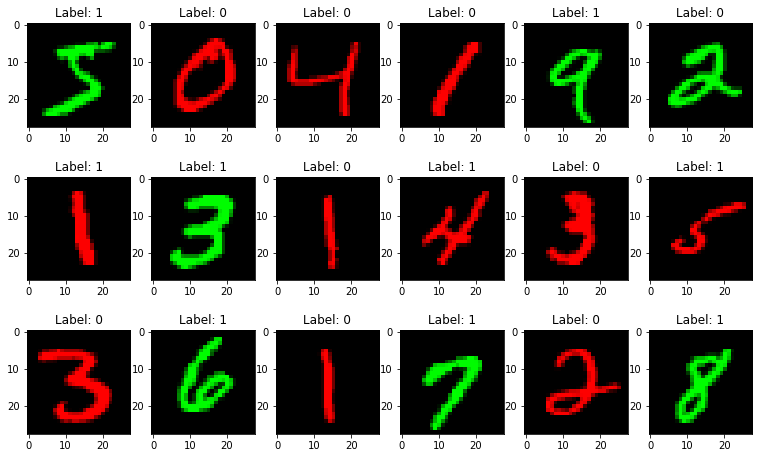

In [15]:
train1_set = ColoredMNIST(root='./data', env='train1')
plot_dataset_digits(train1_set)

In [12]:
import torchvision
torchvision.__version__

'0.10.0+cu102'

Plotting the test set

Colored MNIST dataset already exists


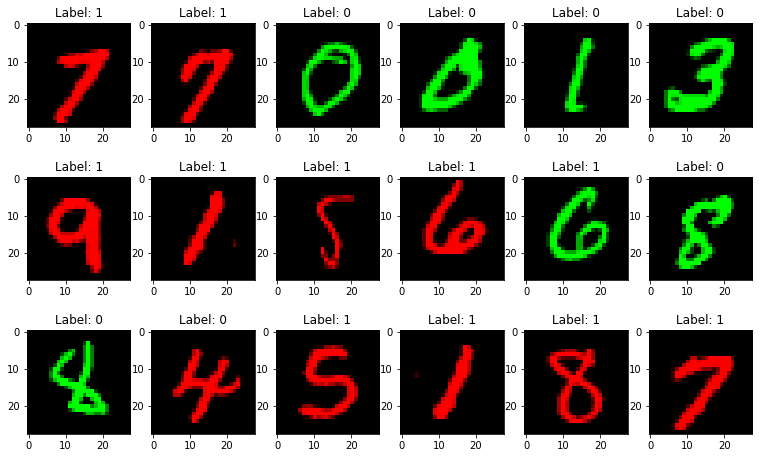

In [16]:
test_set = ColoredMNIST(root='./data', env='test')
plot_dataset_digits(test_set)

Notice how the correlation between color and label are reversed in the train and test set.

## Define neural network

The paper uses an MLP but a Convnet works fine too.

In [17]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(3 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 1)

  def forward(self, x):
    x = x.view(-1, 3 * 28 * 28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x).flatten()
    return logits


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits


## Test ERM as a baseline

Using ERM as a baseline, we expect to train a neural network that uses color instead of the actual digit to classify, completely failing on the test set when the colors are switched.

In [18]:
def test_model(model, device, test_loader, set_name="test set"):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device).float()
      output = model(data)
      test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum').item()  # sum up batch loss
      pred = torch.where(torch.gt(output, torch.Tensor([0.0]).to(device)),
                         torch.Tensor([1.0]).to(device),
                         torch.Tensor([0.0]).to(device))  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nPerformance on {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    set_name, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  return 100. * correct / len(test_loader.dataset)


def erm_train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device).float()
    optimizer.zero_grad()
    output = model(data)
    loss = F.binary_cross_entropy_with_logits(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item()))


def train_and_test_erm():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  all_train_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='all_train',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
    ])),
    batch_size=1000, shuffle=True, **kwargs)

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(1, 2):
    erm_train(model, device, all_train_loader, optimizer, epoch)
    test_model(model, device, all_train_loader, set_name='train set')
    test_model(model, device, test_loader)

train_and_test_erm()

Colored MNIST dataset already exists
Colored MNIST dataset already exists


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/40000 (0%)]	Loss: 0.701294
Train Epoch: 1 [640/40000 (2%)]	Loss: 0.643339
Train Epoch: 1 [1280/40000 (3%)]	Loss: 0.609650
Train Epoch: 1 [1920/40000 (5%)]	Loss: 0.548561
Train Epoch: 1 [2560/40000 (6%)]	Loss: 0.431894
Train Epoch: 1 [3200/40000 (8%)]	Loss: 0.359871
Train Epoch: 1 [3840/40000 (10%)]	Loss: 0.424560
Train Epoch: 1 [4480/40000 (11%)]	Loss: 0.413352
Train Epoch: 1 [5120/40000 (13%)]	Loss: 0.400867
Train Epoch: 1 [5760/40000 (14%)]	Loss: 0.485877
Train Epoch: 1 [6400/40000 (16%)]	Loss: 0.480323
Train Epoch: 1 [7040/40000 (18%)]	Loss: 0.347146
Train Epoch: 1 [7680/40000 (19%)]	Loss: 0.415516
Train Epoch: 1 [8320/40000 (21%)]	Loss: 0.265720
Train Epoch: 1 [8960/40000 (22%)]	Loss: 0.474349
Train Epoch: 1 [9600/40000 (24%)]	Loss: 0.569674
Train Epoch: 1 [10240/40000 (26%)]	Loss: 0.317022
Train Epoch: 1 [10880/40000 (27%)]	Loss: 0.470916
Train Epoch: 1 [11520/40000 (29%)]	Loss: 0.350913
Train Epoch: 1 [12160/40000 (30%)]	Loss: 0.519307
Train Epoch: 1 [12800/4000

## IRM

After trying lots of hyperparameters and various tricks, this implementation 
seems to consistently achieve the paper-reported values 
(train accuracy > 70%, test accuracy > 60%), though there might be a bit of
instability depending on the random seed.

The most common failure case is when the gradient norm penalty term is weighted
too highly relative to the ERM term. In this case, Φ converges to a function that 
returns the same value for all inputs. The classifier cannot recover from this point
and the accuracy is stuck at 50% for all environments. This makes sense mathematically.
If the intermediate representation is the same regardless of input, then *any*
classifier is the ideal classifier, resulting in the penalty gradient being 0.

Another failure case is when the gradient norm penalty is too low and the
optimization essentially acts as in ERM (train accuracy > 80%, test accuracy ~10%).

The most important trick I used to get this to work is through scheduled 
increase of the gradient norm penalty weight.
We start at 0 for the gradient norm penalty weight, essentially beginning as ERM,
then slowly increase it per epoch.

I use early stopping to stop training once the accuracy on all environments, 
including the test set, reach an acceptable value. Yes, stopping training based on 
performance on the test set is not good practice, but I could not
find a principled way of stopping training by only observing performance on the
training environments. One thing that might be needed when applying IRM to
real-world datasets is to leave out a separate environment as a validation set,
which we can use for early stopping. The downside is we'll need a minimum of 4
environments to perform IRM (2 train, 1 validation, 1 test).

In [19]:
def compute_irm_penalty(losses, dummy):
  g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
  g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
  return (g1 * g2).sum()


def irm_train(model, device, train_loaders, optimizer, epoch):
  model.train()

  train_loaders = [iter(x) for x in train_loaders]

  dummy_w = torch.nn.Parameter(torch.Tensor([1.0])).to(device)

  batch_idx = 0
  penalty_multiplier = epoch ** 1.6
  print(f'Using penalty multiplier {penalty_multiplier}')
  while True:
    optimizer.zero_grad()
    error = 0
    penalty = 0
    for loader in train_loaders:
      data, target = next(loader, (None, None))
      if data is None:
        return
      data, target = data.to(device), target.to(device).float()
      output = model(data)
      loss_erm = F.binary_cross_entropy_with_logits(output * dummy_w, target, reduction='none')
      penalty += compute_irm_penalty(loss_erm, dummy_w)
      error += loss_erm.mean()
    (error + penalty_multiplier * penalty).backward()
    optimizer.step()
    if batch_idx % 2 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tERM loss: {:.6f}\tGrad penalty: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loaders[0]),
               100. * batch_idx / len(train_loaders[0]), error.item(), penalty.item()))
      print('First 20 logits', output.data.cpu().numpy()[:20])

    batch_idx += 1


def train_and_test_irm():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  train1_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='train1',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=2000, shuffle=True, **kwargs)

  train2_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='train2',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=2000, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
    ])),
    batch_size=1000, shuffle=True, **kwargs)

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(1, 100):
    irm_train(model, device, [train1_loader, train2_loader], optimizer, epoch)
    train1_acc = test_model(model, device, train1_loader, set_name='train1 set')
    train2_acc = test_model(model, device, train2_loader, set_name='train2 set')
    test_acc = test_model(model, device, test_loader)
    if train1_acc > 70 and train2_acc > 70 and test_acc > 60:
      print('found acceptable values. stopping training.')
      return


In [20]:
train_and_test_irm()

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Using penalty multiplier 1.0
Train Epoch: 1 [0/10 (0%)]	ERM loss: 1.386850	Grad penalty: 0.000011
First 20 logits [0.06876113 0.10738315 0.11077529 0.10935083 0.1441122  0.05708804
 0.12055115 0.08812523 0.12634827 0.10376848 0.0567855  0.13925353
 0.03659127 0.08494531 0.09870582 0.09591392 0.12053084 0.08693725
 0.13352893 0.11873867]
Train Epoch: 1 [4000/10 (20%)]	ERM loss: 0.986962	Grad penalty: 0.033592
First 20 logits [ 0.5838863   0.74792105 -0.69299734  0.53615576 -0.83358395 -1.10514
 -0.83642304 -0.49033174 -0.7856764   0.40436277  0.71425706  0.72921944
 -0.91832995 -1.0522251  -0.99646455  0.59274006 -1.1565285  -1.1264529
  0.5818151  -0.52203697]
Train Epoch: 1 [8000/10 (40%)]	ERM loss: 0.914868	Grad penalty: 0.107239
First 20 logits [-2.8510838  1.6589894 -2.8186865  2.2653022 -2.6885664  3.2823508
  2.0240133  2.614418   2.6277447 -3.3351483  1.3616498  2.63958